In [20]:
#imports
from preprocessing import prepare_dataset
from engine import model_eval
import helper_functions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import kdeplot, histplot

## 0. Preprocessing

In [2]:
X_template, y_template = prepare_dataset(data_dir="data/",
                                      features="Standard")

In [8]:
X_improved, y_improved = prepare_dataset(data_dir="data/",
                                      features="Improved")

## 1. Model Investigation

### 1.1 Template model

In [ ]:
template_model = model_eval(X = X_template, y = y_template, model_type = "OLS")

### 1.2 Ridge regression model

In [ ]:
Ridge_model = model_eval(X = X_improved, y = y_improved, model_type = "Ridge")

### 1.3 XGboost

In [ ]:
xgboost_model = model_eval(X = X_improved, y = y_improved, model_type = "XGboost")

### 1.4 NN default topics

Model Training:   0%|          | 0/1200 [00:00<?, ?it/s]

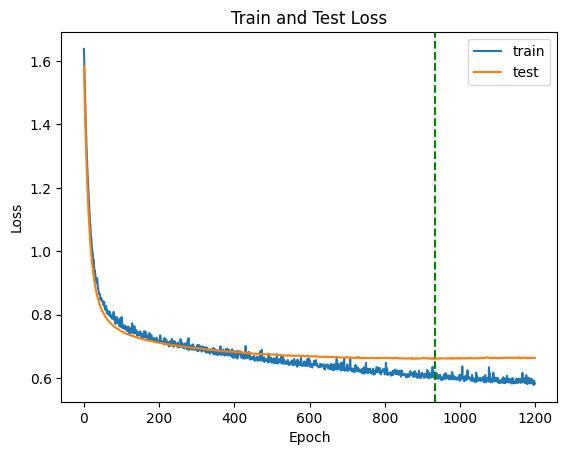

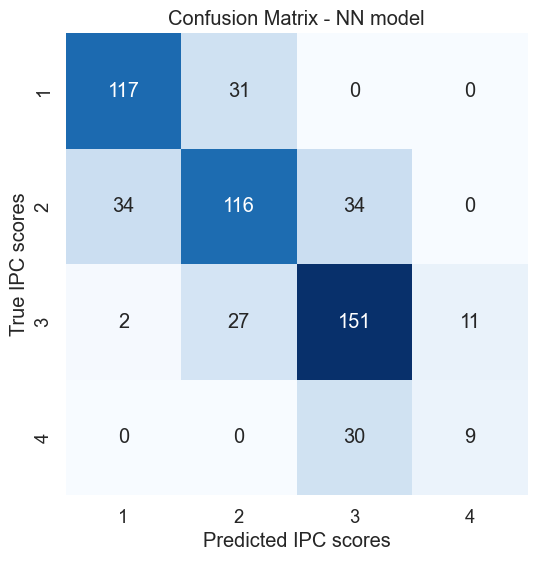

Mean Absolute Error (MAE): 0.304270462633452
Accuracy: 0.699288256227758
F1 Score: 0.6908699262978013


In [4]:
NN_default_model, default_true_labels, default_predicted_probabilities, default_predicted_labels = model_eval(X = X_template,
                                                                                                              y = y_template,
                                                                                                              model_type = "NN")

### 1.5 Final NN

Model Training:   0%|          | 0/1200 [00:00<?, ?it/s]

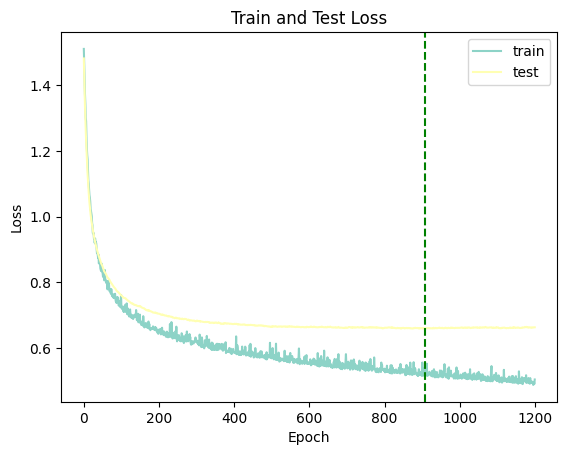

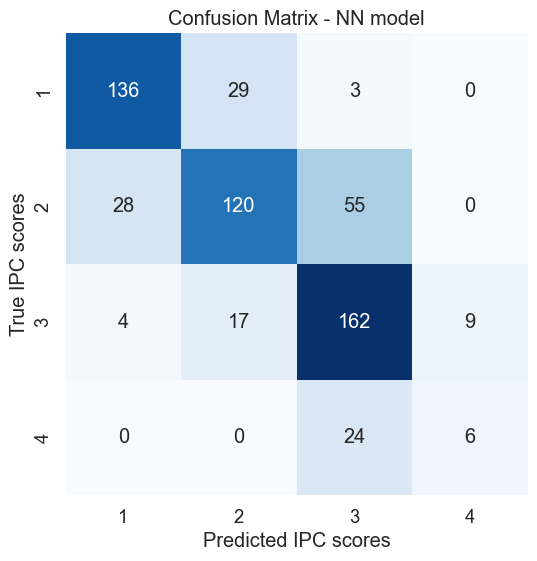

Mean Absolute Error (MAE): 0.29679595278246207
Accuracy: 0.715008431703204
F1 Score: 0.706090083318334


In [9]:
NN_final_model, final_true_labels, final_predicted_probabilities, final_predicted_labels  = model_eval(X = X_improved,
                                                                                                       y = y_improved,
                                                                                                       model_type = "NN")

## 2. Article Utilization

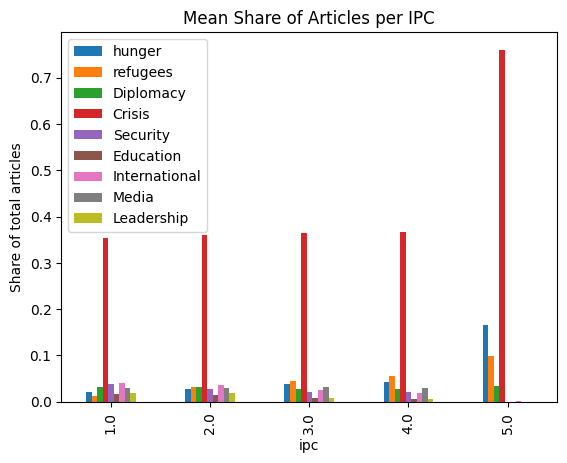

In [3]:
helper_functions.articles_per_ipc(y_template)

Preparing data for the Pie Chart:   0%|          | 0/18520 [00:00<?, ?it/s]

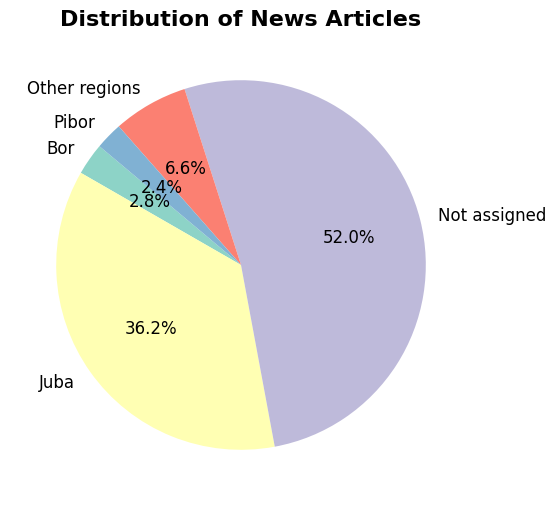

In [3]:
helper_functions.articles_per_region()

## 3. Bias Reduction

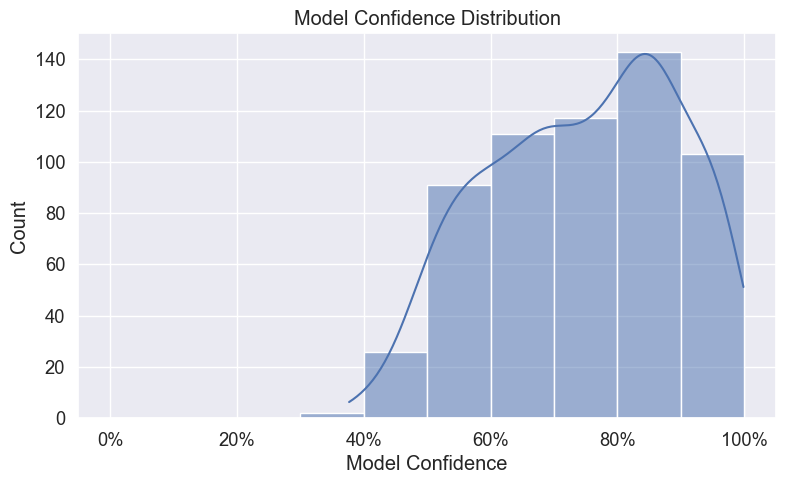

In [22]:
predict_prob_list = np.ndarray(len(final_predicted_probabilities))
predict_class_list = np.ndarray(len(final_predicted_probabilities))

for i in range(len(final_predicted_probabilities)):
    if i % 10 == 0:
        print()
    predict_prob_list[i] = final_predicted_probabilities[i].max()

df_confidence = pd.DataFrame({'true_val': final_true_labels, 'pred_val': final_predicted_labels, 'pred_prob': predict_prob_list})
df_confidence = df_confidence[(df_confidence['pred_prob'] > 0) & (df_confidence['pred_prob'] < 1)]

# Set the figure size
plt.figure(figsize=(9, 5))  # Adjust the width and height as needed
# Create your histogram plot
sns.histplot(df_confidence['pred_prob'], bins=[i/10 for i in range(11)], kde=True)

# Add xlabel, ylabel, and title
plt.xlabel('Model Confidence')
plt.ylabel('Count')
plt.title('Model Confidence Distribution')

# Update the x-axis tick labels to display every 20%
x_ticks = [i/5 for i in range(6)]  # 0.0, 0.2, 0.4, 0.6, 0.8, 1.0
x_labels = [f'{int(x*100)}%' for x in x_ticks]
plt.xticks(x_ticks, x_labels)
# Display the plot
plt.show()

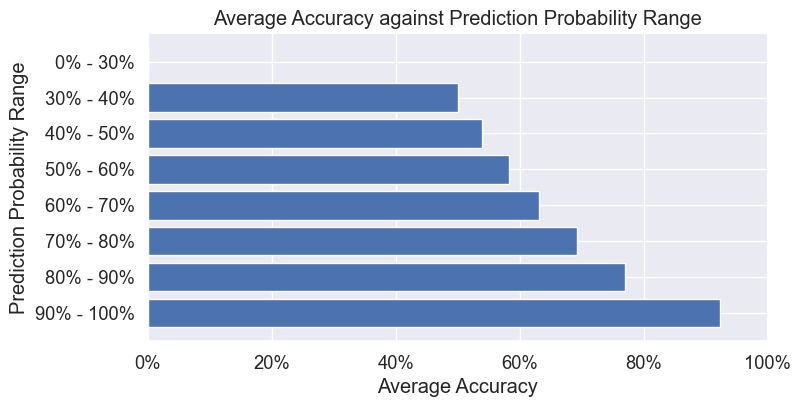

In [23]:
# Define the probability ranges
probability_ranges = [(1.0, 0.9), (0.9, 0.8), (0.8, 0.7), (0.7, 0.6), (0.6, 0.5), (0.5, 0.4), (0.4, 0.3), (0.3, 0.0)]

# Calculate accuracy for each probability range
accuracies = []
for range_start, range_end in probability_ranges:
    subset = df_confidence[(df_confidence['pred_prob'] >= range_end) & (df_confidence['pred_prob'] <= range_start)]
    if len(subset) > 0:
        accuracy = np.sum(subset['true_val'] == subset['pred_val']) / len(subset)
        accuracies.append(accuracy)
    else:
        accuracies.append(0.0)

# Create the histogram
plt.figure(figsize=(8, 4))
plt.barh([f"{int(range_end*100)}% - {int(range_start*100)}%" for range_start, range_end in probability_ranges], accuracies)
plt.xlabel('Average Accuracy')
plt.ylabel('Prediction Probability Range')
plt.title('Average Accuracy against Prediction Probability Range')
plt.xlim(0, 1)

# Define a function to format the x-axis ticks as percentages
def percentage_formatter(x, pos):
    return f"{int(x * 100)}%"

# Modify the x-axis ticks to display as percentages
x_ticks_percentages = [f"{int(x*100)}%" for x in plt.xticks()[0]]
plt.xticks(plt.xticks()[0], x_ticks_percentages)


plt.show()